# The follwing is aim to represnt vissualy the results

In [276]:
from __future__ import print_function, division

from tqdm import tqdm, tqdm_notebook
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from numpy.typing import NDArray
from functools import reduce
from itertools import islice
import wandb
import math
from itertools import chain
import copy
from PIL import Image

import torch
from torch import nn
from torch import Tensor
from torch.optim import Optimizer
import torch.nn.functional as F
import torchvision 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchsummary import summary
# Import albumentations library in order to -use pre-built augmentations
import albumentations as A

from sklearn.model_selection import train_test_split
from multiprocessing import cpu_count

import os
import torch
import os.path as osp
from skimage import io, transform
import matplotlib.pyplot as plt
import typing as ty
import cv2

# ---

In [277]:
DATA_DIR = 'AF_dataset'
BATCH_SIZE = 32

img_dir = osp.join(DATA_DIR, "images")
hw_real=640
h, w, c = 255, 255, 3 # The heigh, width and number of channels of each image

# Here we map each class to an index from 0 to n_classes - 

df = pd.read_csv(osp.join(DATA_DIR, "train.csv"))

df['class_id'] = np.where(df['class_id']==2,1,0)

obj2id = {
    "penguin": 0, 
    "turtle": 1
}

id2obj = {
    0: "penguin",
    1: "turtle"
}

#df["class_id"] = df["class"].map(obj2id)
df['xmax'] = df['xmin'] + df['xmax']
df['ymax'] = df['ymin'] + df['ymax']
#df[["xmin", "ymin", "xmax", "ymax"]] /= h

df["class"] = df["class_id"].map(id2obj)

#df["class_id"] = df["class"].map(obj2id)


In [278]:

df_predicted = pd.read_csv("submission_full_test.csv")


df_predicted['pred_class_id'] = np.where(df_predicted['pred_class_id']==2,1,0)

obj2id = {
    "penguin": 0, 
    "turtle": 1
}

id2obj = {
    0: "penguin",
    1: "turtle"
}


df_predicted['pred_xmax'] = df_predicted['pred_xmin'] + df_predicted['pred_xmax']
df_predicted['pred_ymax'] = df_predicted['pred_ymin'] + df_predicted['pred_ymax']


df_predicted["class"] = df_predicted["pred_class_id"].map(id2obj)

df_predicted


,filename,pred_class_id,pred_xmin,pred_ymin,pred_xmax,pred_ymax,true_class_id,true_xmin,true_ymin,true_xmax,true_ymax,class
0,image_id_233_.jpg,1,183.742220,227.342730,438.021850,388.678240,1,195,269,284,213,turtle
1,image_id_258_.jpg,0,113.250690,117.729270,252.255300,451.465050,0,111,172,153,453,penguin
2,image_id_201_.jpg,1,116.838380,171.733580,476.832950,349.807910,1,152,242,332,153,turtle
3,image_id_325_.jpg,1,232.058900,124.741330,647.350370,461.628170,1,284,104,305,292,turtle
4,image_id_297_.jpg,1,262.565670,352.934700,606.357690,662.730750,1,217,344,306,262,turtle
5,image_id_523_.jpg,1,40.923008,129.791870,674.917458,566.743220,1,61,128,529,390,turtle
6,image_id_279_.jpg,1,73.031494,125.643540,458.534974,327.172410,1,141,186,339,221,turtle
7,image_id_271_.jpg,1,83.512924,151.936510,454.238924,374.696410,1,156,250,362,201,turtle
8,image_id_346_.jpg,1,153.145230,217.160320,552.842650,519.737620,1,138,193,325,301,turtle
9,image_id_128_.jpg,1,154.702880,226.046140,414.683560,351.458910,1,167,267,288,115,turtle


In [279]:
df[["xmin", "ymin", "xmax", "ymax"]] /= hw_real

In [280]:
df_predicted[["pred_xmin", "pred_ymin", "pred_xmax", "pred_ymax"]] /= hw_real

In [281]:
train_df, val_df = train_test_split(
    df, stratify=df['class_id'], test_size=0.25#, random_state=RANDOM_SEED
)

print(train_df.shape)
print(val_df.shape)

(355, 8)
(119, 8)


In [282]:
train_df

,filename,xmin,ymin,xmax,ymax,class_id,new_split,class
202,image_id_245_.jpg,0.217188,0.201563,0.457813,0.862500,0,train,penguin
464,image_id_560_.jpg,0.000000,0.164062,0.943750,0.856250,1,train,turtle
323,image_id_395_.jpg,0.154688,0.256250,0.854688,0.679688,1,train,turtle
200,image_id_243_.jpg,0.267188,0.428125,0.732812,0.768750,1,train,turtle
244,image_id_295_.jpg,0.392188,0.257812,0.743750,0.810937,0,train,penguin
...,...,...,...,...,...,...,...,...
403,image_id_487_.jpg,0.101562,0.176563,0.812500,0.796875,1,train,turtle
236,image_id_286_.jpg,0.689063,0.092188,0.901563,0.968750,0,train,penguin
207,image_id_252_.jpg,0.237500,0.343750,0.776563,0.645312,1,train,turtle
467,image_id_564_.jpg,0.020313,0.082812,0.825000,0.953125,0,train,penguin


In [283]:
classes = df["class"].unique()
classes

array(['penguin', 'turtle'], dtype=object)

In [284]:
val_df['class_id'].value_counts(1) * 100

class_id
0    50.420168
1    49.579832
Name: proportion, dtype: float64

In [285]:
transform_func_inp_signature = ty.Dict[str, NDArray[np.float_]]
transform_func_signature = ty.Callable[
    [transform_func_inp_signature],
    transform_func_inp_signature
]

class imageDataset(Dataset):
    """
    Location image dataset
    """
    def __init__(
        self, 
        df: pd.DataFrame, 
        root_dir: str, 
        labeled: bool = True,
        transform: ty.Optional[ty.List[transform_func_signature]] = None,
        output_size: ty.Optional[tuple] = None  # Añadir parámetro para tamaño de salida
    ) -> None:
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        self.labeled = labeled
        self.output_size = output_size  # Almacenar el tamaño de salida
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx: int) -> transform_func_signature: 
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Read image
        img_name = os.path.join(self.root_dir, self.df.filename.iloc[idx])
        image = io.imread(img_name)
        
        #print(f"Dimensiones originales de la imagen: {image.shape}")  # Agregar para depuración

        if image.ndim == 2:  # Si la imagen está en escala de grises
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)  # Convertir a RGB
        elif image.shape[2] == 4:  # Si la imagen es RGBA
            image = image[:, :, :3] 
            
        # Redimensionar la imagen si se especifica un tamaño de salida
        if self.output_size:
            image = cv2.resize(image, self.output_size)
        
        sample = {'image': image}
        
        if self.labeled:
            img_class = self.df.class_id.iloc[idx]
            img_bbox = self.df.iloc[idx, 1:5]

            img_bbox = np.array([img_bbox]).astype('float')
            print(img_bbox)
            img_class = np.array([img_class]).astype('int')
            sample.update({'bbox': img_bbox, 'class_id': img_class})#,'name_class':name_class,'w': img_w, 'h': img_h
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [286]:
transform_func_inp_signature = ty.Dict[str, NDArray[np.float_]]
transform_func_signature = ty.Callable[
    [transform_func_inp_signature],
    transform_func_inp_signature
]

class ImageDataset(Dataset):
    """
    Location image dataset
    """
    def __init__(
        self, 
        df: pd.DataFrame, 
        root_dir: str, 
        labeled: bool = True,
        transform: ty.Optional[ty.List[transform_func_signature]] = None,
        output_size: ty.Optional[tuple] = None  # Añadir parámetro para tamaño de salida
    ) -> None:
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        self.labeled = labeled
        self.output_size = output_size  # Almacenar el tamaño de salida
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx: int) -> transform_func_signature: 
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Read image
        img_name = os.path.join(self.root_dir, self.df.filename.iloc[idx])
        image = io.imread(img_name)
        
        #print(f"Dimensiones originales de la imagen: {image.shape}")  # Agregar para depuración

        if image.ndim == 2:  # Si la imagen está en escala de grises
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)  # Convertir a RGB
        elif image.shape[2] == 4:  # Si la imagen es RGBA
            image = image[:, :, :3] 
            
        # Redimensionar la imagen si se especifica un tamaño de salida
        if self.output_size:
            image = cv2.resize(image, self.output_size)
        
        sample = {'image': image}
        
        if self.labeled:
            # print(self.df.pred_class_id)
            img_class = self.df.pred_class_id.iloc[idx]
            img_bbox = self.df.iloc[idx, 2:6]
            img_bbox = np.array([img_bbox]).astype('float')
            img_class = np.array([img_class]).astype('int')
            sample.update({'bbox': img_bbox, 'class_id': img_class})
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [287]:
def draw_bbox(img, bbox, color):
    xmin, ymin, xmax, ymax = bbox
    img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, 2)
    return img

def normalize_bbox(bbox, factor : int = 255):
    return list(map(lambda x: int(x * factor), bbox))

def draw_bboxes(imgs, bboxes, colors):
    for i, (img, bbox, color) in enumerate(zip(imgs, bboxes, colors)):
        imgs[i] = draw_bbox(img, bbox, color)
    return imgs

def draw_classes(imgs, classes, colors, origin, offset: int = 5, prefix: str =''):
    for i, (img, class_id, color) in enumerate(zip(imgs, classes, colors)): 
        if type(c)==list:
            name_class_=id2obj[classes[i]]
        else:
            name_class_=id2obj[classes[i][0]]
        imgs[i] = cv2.putText(
            img, f'{prefix}{name_class_}', #class_id.squeeze()
            origin, cv2.FONT_HERSHEY_SIMPLEX, 
            0.4, color, 1, cv2.LINE_AA
        )
    return imgs

def draw_predictions(imgs, classes, bboxes, colors, origin):
    assert all(len(x) > 0 for x in [imgs, classes, bboxes, colors])
    if len(colors) == 1:
        colors = [colors[0] for _ in imgs]
    imgs = draw_bboxes(imgs, bboxes, colors)
    imgs = draw_classes(imgs, classes, colors, origin)
    return imgs

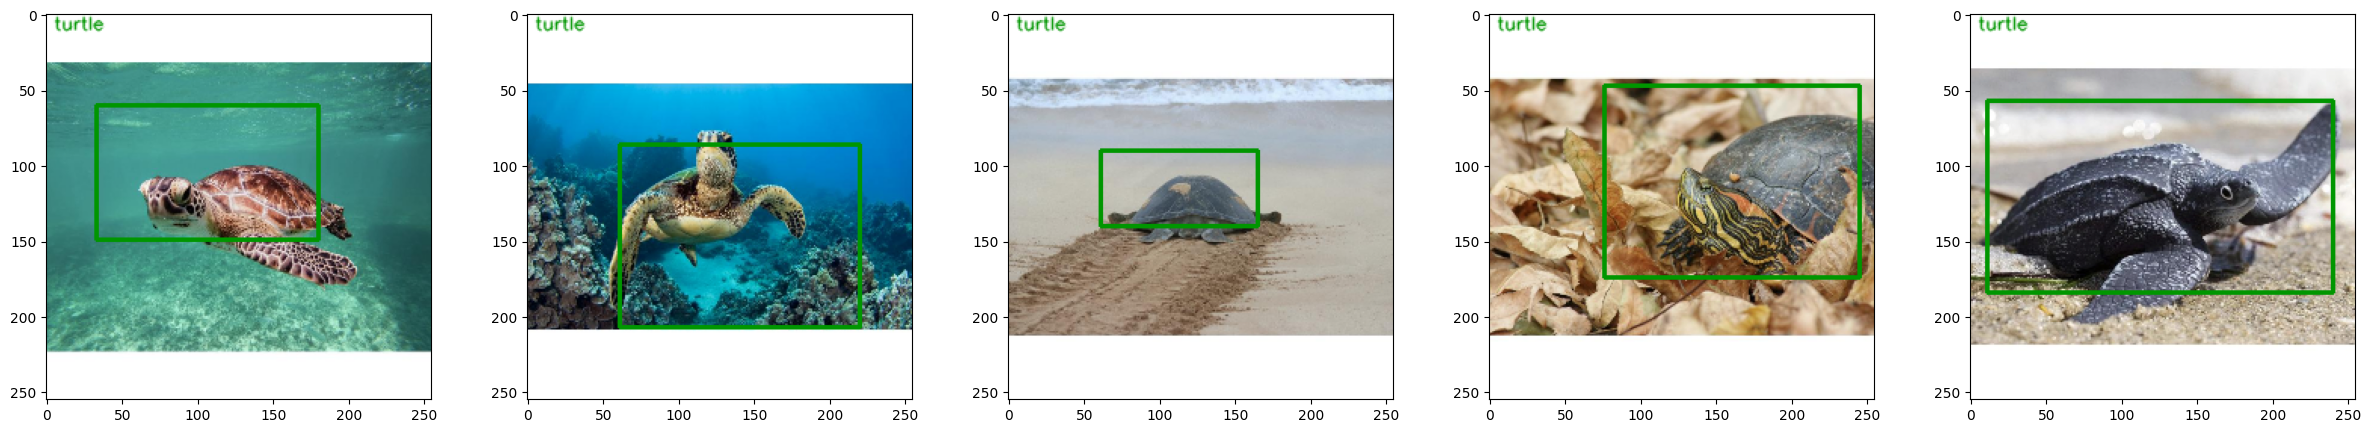

In [302]:
import random as rand
train_root_dir = osp.join(DATA_DIR, "images")

train_ds = ImageDataset(df_predicted, root_dir=train_root_dir,output_size=(255,255))

num_imgs = 5
start_idx = rand.randint(0, len(train_ds) - num_imgs)



samples = [train_ds[i] for i in range(start_idx, start_idx + num_imgs)]


imgs = [s['image'] for s in samples]
bboxes = [normalize_bbox(s['bbox'].squeeze()) for s in samples]


classes = [s['class_id'] for s in samples]
imgs = draw_predictions(imgs, classes, bboxes, [(0, 150, 0)], (5, 10))#(150, 10)
classes

fig = plt.figure(figsize=(30, num_imgs))

for i, img in enumerate(imgs):
    fig.add_subplot(1, num_imgs, i+1)
    plt.imshow(img)

plt.show()

In [289]:
# train_root_dir = osp.join(DATA_DIR, "images")#, "train"
# train_ds = imageDataset(train_df, root_dir=train_root_dir,output_size=(255,255))


# num_imgs = 6
# start_idx = 0

# samples = [train_ds[i] for i in range(start_idx, num_imgs)]
# imgs = [s['image'] for s in samples]
# bboxes = [normalize_bbox(s['bbox'].squeeze()) for s in samples]
# bboxes


# classes = [s['class_id'] for s in samples]
# imgs = draw_predictions(imgs, classes, bboxes, [(0, 150, 0)], (5, 10))#(150, 10)
# classes

# fig = plt.figure(figsize=(30, num_imgs))

# for i, img in enumerate(imgs):
#     fig.add_subplot(1, num_imgs, i+1)
#     plt.imshow(img)

# plt.show()

In [290]:
train_df

,filename,xmin,ymin,xmax,ymax,class_id,new_split,class
202,image_id_245_.jpg,0.217188,0.201563,0.457813,0.862500,0,train,penguin
464,image_id_560_.jpg,0.000000,0.164062,0.943750,0.856250,1,train,turtle
323,image_id_395_.jpg,0.154688,0.256250,0.854688,0.679688,1,train,turtle
200,image_id_243_.jpg,0.267188,0.428125,0.732812,0.768750,1,train,turtle
244,image_id_295_.jpg,0.392188,0.257812,0.743750,0.810937,0,train,penguin
...,...,...,...,...,...,...,...,...
403,image_id_487_.jpg,0.101562,0.176563,0.812500,0.796875,1,train,turtle
236,image_id_286_.jpg,0.689063,0.092188,0.901563,0.968750,0,train,penguin
207,image_id_252_.jpg,0.237500,0.343750,0.776563,0.645312,1,train,turtle
467,image_id_564_.jpg,0.020313,0.082812,0.825000,0.953125,0,train,penguin
